In [2]:
import torch
import torch.nn as nn
import torch as pt
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch.optim as optim
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from tqdm import trange

# HCP Data using Simeon preproc

## Function definitions

In [3]:
# From DBGDGM code

def create_fc_matrices(scan, window_size=30, step_size=10):
    """
    Create functional connectivity matrices using a sliding window approach.
    Function from DBGDGM code.
    """
    n_timepoints = scan.shape[1]
    fc_matrices = []

    for start in range(0, n_timepoints - window_size + 1, step_size):
        window = scan[:, start:start + window_size]
        correlation_matrix = np.corrcoef(window)   # pearson correlation 
        fc_matrices.append(correlation_matrix)

    return fc_matrices


def threshold_fc_matrix(fc_matrix, percentile=5):
    """
    Threshold the FC matrix to keep only the top percentile connections.
    """
    threshold = np.percentile(fc_matrix[np.tril_indices_from(fc_matrix, k=-1)], 100 - percentile)   
    graph = (fc_matrix > threshold).astype(int)
    np.fill_diagonal(graph, 0)  # remove self-edges
    return graph


def create_networkx_graph(matrix):
    G = nx.Graph(matrix)
    return G


def convert_to_pyg_graph(nx_graph, label):
    graph = nx.Graph(nx_graph)
    edges = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(np.identity(graph.number_of_nodes()), dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edges, y=y)

In [4]:
# From DBGDSL code

def create_fc_matrices_dbgsl(scan, window_size=30, step_size=10):
    """
    Create functional connectivity matrices using a sliding window approach.
    Function created using DBGSL code to split data into windows.
    """
    n_timepoints = scan.shape[1]
    t_repetition = (n_timepoints - 2*(window_size - 1) - 1)//(step_size + 1)
    fc_matrices = []

    for t in range(t_repetition):
        window = scan[:, t*step_size:t*step_size+window_size]
        correlation_matrix = (np.corrcoef(window) + 1) / 2   # normalized pearson correlation 
        fc_matrices.append(correlation_matrix)

    return fc_matrices

def get_x_split(x: pt.Tensor, stride, len_window, t_repetition) -> pt.Tensor:
    x_split = pt.stack([x[:, :, t*stride:t*stride+len_window] for t in range(t_repetition)], 1)
    return x_split.float()

def get_node_features(x_split: pt.Tensor) -> pt.Tensor:
    x_split_avg = pt.mean(x_split, -1, keepdim=True)
    x_split_std = pt.std(x_split, -1, keepdim=True)
    x_split_cov = pt.matmul(x_split - x_split_avg, pt.transpose(x_split - x_split_avg, 2, 3))
    node_features = x_split_cov/pt.matmul(x_split_std, pt.transpose(x_split_std, 2, 3))
    return node_features

def get_coo(adjacency_matrix: pt.Tensor) -> pt.Tensor:
    i = 0
    edge_indices = pt.nonzero(adjacency_matrix > 0, as_tuple=False).T
    edge_index_batch = pt.clone(edge_indices[1:3, :])
    for t in range(len(edge_indices[0])):
        if i < edge_indices[0][t]:
            i = i + 1
            n_nodes = max(edge_indices[1][t-1], edge_indices[2][t-1])+1
            edge_index_batch[0][t:] = edge_index_batch[0][t:] + n_nodes
            edge_index_batch[1][t:] = edge_index_batch[1][t:] + n_nodes
    edge_attr_batch = adjacency_matrix[adjacency_matrix > 0].unsqueeze(-1)
    batch = edge_indices[0]
    return edge_index_batch, edge_attr_batch, batch


def construct_graph(x_ebd: torch.Tensor) -> torch.Tensor:
    batch_size = x_ebd.shape[0]
    batch_adjacency_matrices = []

    for i in range(batch_size):
        sample = x_ebd[i]
        sample = F.softmax(sample, -1)
        adjacency_matrix = torch.matmul(sample, sample.transpose(1, 2))
        batch_adjacency_matrices.append(adjacency_matrix)
    adjacency_matrix_batch = torch.stack(batch_adjacency_matrices, dim=0)

    return adjacency_matrix_batch

def sparsify(adjacency_matrix_batch: torch.Tensor) -> torch.Tensor:
    threshold = torch.nn.parameter.Parameter(torch.full((1,), -5.0))
    batch_sparse_adjacency = []

    for i in range(adjacency_matrix_batch.size(0)):
        adjacency_matrix = adjacency_matrix_batch[i]
        sparse_adjacency = F.relu(adjacency_matrix - torch.sigmoid(threshold))
        batch_sparse_adjacency.append(sparse_adjacency)
    sparse_adjacency_batch = torch.stack(batch_sparse_adjacency, dim=0)

    return sparse_adjacency_batch

In [5]:
# From DBGSL code

class InceptionTC(nn.Module):
    def __init__(self, itcn_d, dilation):
        super(InceptionTC, self).__init__()
        self.t_conv_0 = nn.Conv1d(itcn_d, itcn_d//3, kernel_list[0], dilation=dilation, padding=(kernel_list[0]-1)*dilation)
        self.t_conv_1 = nn.Conv1d(itcn_d, itcn_d//3, kernel_list[1], dilation=dilation, padding=(kernel_list[1]-1)*dilation)
        self.t_conv_2 = nn.Conv1d(itcn_d, itcn_d//3, kernel_list[2], dilation=dilation, padding=(kernel_list[2]-1)*dilation)
        self.bn = nn.BatchNorm1d(itcn_d)

    def forward(self, x_split, dilation):
        x_cat = [
            self.clip_end(self.t_conv_0(x_split), 0, dilation),
            self.clip_end(self.t_conv_1(x_split), 1, dilation),
            self.clip_end(self.t_conv_2(x_split), 2, dilation)
        ]
        x_cat = torch.cat(x_cat, 1)
        x_out = F.relu(self.bn(x_cat))
        return x_out

    def clip_end(self, x, i, dilation):
        padding = (kernel_list[i] - 1) * dilation
        x = x[:, :, :-padding].contiguous()
        return x


class ITCN(nn.Module):
    def __init__(self, batch_size, n_neurons, itcn_d, t_repetition, kernel_list):
        super(ITCN, self).__init__()
        self.batch_size = batch_size
        self.n_neurons = n_neurons
        self.itcn_d = itcn_d
        self.t_repetition = t_repetition
        self.kernel_list = kernel_list
        self.inception_tc_2 = InceptionTC(itcn_d, 2)  
        self.inception_tc_4 = InceptionTC(itcn_d, 4)
        self.inception_tc_6 = InceptionTC(itcn_d, 6)

    def forward(self, x_split):
        x_split = x_split.reshape(self.batch_size * self.n_neurons, self.itcn_d, self.t_repetition)
        x_split = self.inception_tc_2(x_split, 2)
        x_split = self.inception_tc_4(x_split, 4)
        x_split = self.inception_tc_6(x_split, 6)
        x_split = x_split.reshape(self.batch_size, self.t_repetition, self.n_neurons, self.itcn_d)
        return x_split


class RegionEmbedding(nn.Module):
    def __init__(self, len_window, itcn_d, ebd_d, batch_size, n_neurons, t_repetition, kernel_list):
        super(RegionEmbedding, self).__init__()
        self.input_layer = nn.Linear(len_window, itcn_d)
        self.itcn_layer = ITCN(batch_size, n_neurons, itcn_d, t_repetition, kernel_list)
        self.output_fc = nn.Sequential(nn.Linear(itcn_d, itcn_d), nn.ReLU(), nn.Linear(itcn_d, ebd_d))

    def forward(self, x_split):
        x_split = self.input_layer(x_split)
        x_split = self.itcn_layer(x_split)
        x_split = self.output_fc(x_split)
        return x_split


class SpatialAttention(nn.Module):
    def __init__(self, n_neurons, tau):
        super(SpatialAttention, self).__init__()
        n_neurons_ebd = int(tau * n_neurons)
        self.spatial_attn = nn.Sequential(
            nn.Linear(n_neurons, n_neurons_ebd, bias=False),
            nn.ReLU(),
            nn.Linear(n_neurons_ebd, n_neurons, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x_ebd):
        x_spatial_attn = torch.mean(x_ebd, -1)
        x_spatial_attn = self.spatial_attn(x_spatial_attn)
        x_spatial_attn = x_spatial_attn.unsqueeze(-1)
        return x_spatial_attn


class TemporalAttention(nn.Module):
    def __init__(self, t_repetition, tau, n_neurons, ebd_d):
        super(TemporalAttention, self).__init__()
        T_ebd = int(tau * t_repetition)
        self.temporal_attn = nn.Sequential(
            nn.Linear(t_repetition, T_ebd, bias=False),
            nn.ReLU(),
            nn.Linear(T_ebd, t_repetition, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x_ebd):
        x_temporal_attn = x_ebd.view(-1, t_repetition, n_neurons * ebd_d)
        x_temporal_attn = torch.mean(x_temporal_attn, -1)
        x_temporal_attn = self.temporal_attn(x_temporal_attn)
        x_temporal_attn = x_temporal_attn.view(-1, t_repetition, 1, 1)
        return x_temporal_attn


class MyModel(nn.Module):
    def __init__(self, len_window, itcn_d, ebd_d, batch_size, n_neurons, t_repetition, tau, kernel_list):
        super(MyModel, self).__init__()
        self.region_embd = RegionEmbedding(len_window, itcn_d, ebd_d, batch_size, n_neurons, t_repetition, kernel_list)
        self.spat_attention = SpatialAttention(n_neurons, tau)
        self.temp_attention = TemporalAttention(t_repetition, tau, n_neurons, ebd_d)

    def forward(self, x):
        x_ebd = self.region_embd(x)
        x_spatial_attention = self.spat_attention(x_ebd)
        x_ebd = x_spatial_attention * x_ebd
        x_temporal_attn = self.temp_attention(x_ebd)
        x_ebd = x_temporal_attn * x_ebd
        return x_ebd


## Example of tensor dimensions

In [8]:
# ----------- One raw as example -------------------------

data_path = '../data/hcp/raw'
file_name = '100206_0.npy'
file_path = os.path.join(data_path, file_name)
print('FILE_PATH: ', file_path)
time_series_data = np.load(file_path)[:, :490]
print('time_series_data SHAPE: ', time_series_data.shape)
label = int(os.path.basename(file_path).split('_')[-1].split('.')[0])

fc_matrices = create_fc_matrices(time_series_data) # --> dbgdgm way of slicing the timeseries
fc_matrices_tn = torch.tensor(fc_matrices).reshape(1, len(fc_matrices), 360, 360)
print('fc_matrices_tn SHAPE (slicing as in DBGDGM code): ', fc_matrices_tn.shape)
fc_matrices_dbgsl = create_fc_matrices_dbgsl(time_series_data)
fc_matrices_dbgsl_tn = torch.tensor(fc_matrices_dbgsl).reshape(1, len(fc_matrices_dbgsl), 360, 360) # --> dbgsl way of slicing the timeseries
print('fc_matrices_39 SHAPE (slicing as in DBGSL code): ', fc_matrices_dbgsl_tn.shape)

graphs = [threshold_fc_matrix(fc) for fc in fc_matrices] 
graph = graphs[0]
graph_nx = convert_to_pyg_graph(graph, label)

# ----------- One raw as example -------------------------


FILE_PATH:  ../data/hcp/raw/100206_0.npy
time_series_data SHAPE:  (360, 490)


/tmp/ipykernel_3786975/983908113.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  fc_matrices_tn = torch.tensor(fc_matrices).reshape(1, len(fc_matrices), 360, 360)


fc_matrices_tn SHAPE (slicing as in DBGDGM code):  torch.Size([1, 47, 360, 360])
fc_matrices_39 SHAPE (slicing as in DBGSL code):  torch.Size([1, 39, 360, 360])


### Hyperparameters

In [9]:
batch_size = 1   # remember to change
T = 490
len_window = 30   
stride = 10  
t_repetition = (T - 2*(len_window - 1) - 1)//(stride + 1)
print('t_repetition: ', t_repetition)

# Training hyperparameters
device = 'cpu'
n_neurons = 360
lr = 0.003  # learning rate, 0.003
# n_episodes = 1000   # n_epochs, remember to change -> moved below
n_itcn_layers = 3
n_gru_layers = 1
tau = 0.1
kernel_list = [3, 5, 7]
itcn_d = 9
ebd_d = 3
gcn_d = 5
n_classes = 1

time_series_torch = torch.from_numpy(time_series_data).reshape(batch_size, time_series_data.shape[0], time_series_data.shape[1])
print('RESHAPING time_series_data: ', time_series_torch.shape)

x_split = get_x_split(time_series_torch, stride, len_window, t_repetition)
print('SPLITTING WINDOW time_series_data: ', x_split.shape)

t_repetition:  39
RESHAPING time_series_data:  torch.Size([1, 360, 490])
SPLITTING WINDOW time_series_data:  torch.Size([1, 39, 360, 30])


### Dataset building

In [10]:
data_path = '../data/hcp/raw'
dataset_input = []
dataset_ground = []
for file_name in os.listdir(data_path):
    if file_name.endswith(".npy"):
        # get raw data
        file_path = os.path.join(data_path, file_name)
        # truncate the timeseries
        time_series_data = np.load(file_path)[:, :490]
        time_series_torch = torch.from_numpy(time_series_data).reshape(1, 
                                             time_series_data.shape[0], time_series_data.shape[1])
        # get splitting windows
        x_split = get_x_split(time_series_torch, stride, len_window, t_repetition)
        dataset_input.append(x_split)

        # create FC matrices based on the previous splitted windows
        fc_matrices = create_fc_matrices_dbgsl(time_series_data)
        fc_matrices_tn = torch.tensor(fc_matrices).reshape(1, len(fc_matrices), 360, 360)

        # for our first training, we will assume that FC matrices already created are the training objective
        ground_truth = fc_matrices_tn.float()
        dataset_ground.append(ground_truth)

In [11]:
input_tensor = torch.cat(dataset_input, dim=0)
ground_truth_tens = torch.cat(dataset_ground, dim=0)
print(input_tensor.shape)
print(ground_truth_tens.shape)

torch.Size([300, 39, 360, 30])
torch.Size([300, 39, 360, 360])


In [46]:
# Instantiate your model
model = MyModel(len_window, itcn_d, ebd_d, batch_size, n_neurons, t_repetition, tau, kernel_list)

## Training

### One subject only

In [12]:
print('x_split shape (data splitted into time windows): ', dataset_input[0].shape)
print('fc_matrices_dgbsl shape (final graph): ', dataset_ground[0].shape)

x_split shape (data splitted into time windows):  torch.Size([1, 39, 360, 30])
fc_matrices_dgbsl shape (final graph):  torch.Size([1, 39, 360, 360])


In [47]:
subject = 0
n_episodes = 5000   # n_epochs, remember to change

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_arr = np.zeros(n_episodes)

ground_truth = dataset_ground[subject].float()
epochs = trange(n_episodes)
for epoch in epochs:
    optimizer.zero_grad()
    outputs = model(dataset_input[subject])
    adjacency_matrix = construct_graph(outputs)
    # loss = criterion(adjacency_matrix, ground_truth)
    # sparse_adjacency = sparsify(adjacency_matrix)
    loss = criterion(adjacency_matrix, ground_truth)
    loss.backward()
    optimizer.step()
    loss_arr[epoch] = loss.item()

    epochs.set_postfix({'Loss': loss.item()})

100%|██████████| 5000/5000 [08:00<00:00, 10.41it/s, Loss=0.0102]


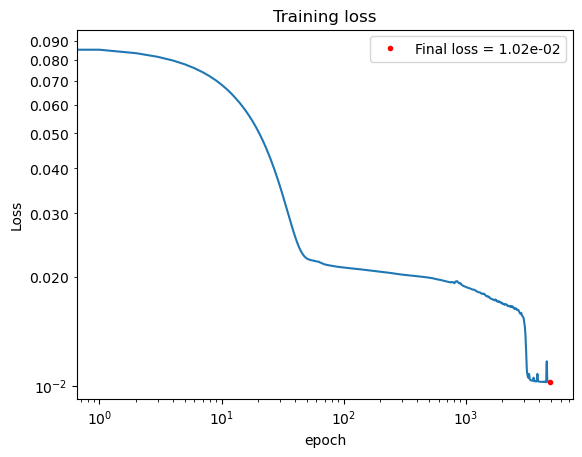

In [59]:
fig = plt.figure()
ax = fig.gca()
ax.set_yscale('log')
ax.set_xscale('log')
periods = 50
# Mobile mean of the loss
loss_mm = np.convolve([1/periods]*periods, loss_arr)[periods:-periods] 
ax.plot(loss_mm)
ax.plot(n_episodes-periods, loss_mm[-1], '.', color = "red", label=f'Final loss = {loss_arr[-periods:].mean():.2e}')

# ax.set_yticklabels(np.arange(0.01, 0.1, 0.01))
ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())

plt.title("Training loss")

# ax.set_xlim(periods, n_epochs)
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")

plt.legend(loc=1)

plt.show()

### Visualising Adjacency Matrix results

In [6]:
output_graph = np.load('../data/adj_matrices_files/final_graph_subj0.npy')

In [14]:
# np.save('../data/adj_matrices_files/fc_matrix_subj0.npy', dataset_ground[0])
adj_matrice = np.load('../data/adj_matrices_files/fc_matrix_subj0.npy')

In [7]:
output_graph.shape

(1, 39, 360, 360)

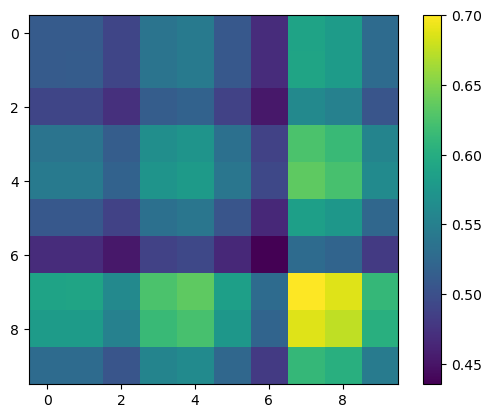

In [18]:
plt.imshow(output_graph[0][0][:10,:10])
plt.colorbar()

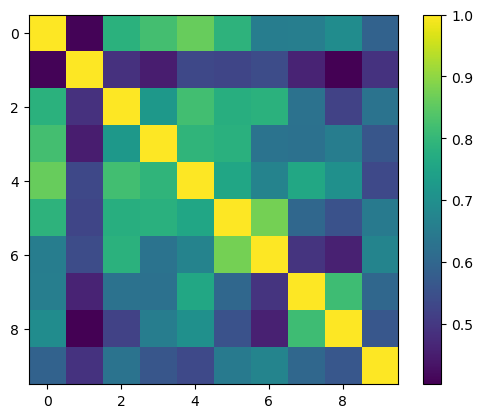

In [19]:
plt.imshow(adj_matrice[0][0][:10,:10])
plt.colorbar()

In [37]:
diff = adj_matrice[0][0] - output_graph[0][0]

In [38]:
diff.shape

(360, 360)

In [39]:
np.fill_diagonal(diff, 0)

In [41]:
np.abs(diff).max()

0.56758195

In [ ]:
# TODO:
""" 
- store predicted matrix every tot epochs
- compute difference between predicted matrix and ground truth
- plot the evolution of differences in a dinamic way 
- construct a distribution of difference values (with mean and variance) for a single timepoint (?)

"""




### Multiple subjects

In [ ]:
train_len = 240
test_len = 60

train_input = input_tensor[:train_len]
test_input = input_tensor[train_len:train_len+test_len]
train_ground = ground_truth_tens[:train_len]
test_ground = ground_truth_tens[train_len:train_len+test_len]

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

n_samples_train = train_input.size(0)
n_batches_train = n_samples_train // batch_size

for epoch in range(n_episodes):
    total_loss = 0.0
    model.train()
    for i in range(n_batches_train):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        x_split_batch = train_input[start_idx:end_idx]
        ground_truth_batch = train_ground[start_idx:end_idx]
        optimizer.zero_grad()
        outputs = model(x_split_batch)
        adjacency_matrix = construct_graph(outputs)
        sparse_adjacency = sparsify(adjacency_matrix)
        loss = criterion(sparse_adjacency, ground_truth_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / n_batches_train
    print(f'Epoch {epoch + 1}/{n_episodes}, Average Loss: {average_loss}')

In [ ]:
n_samples_test = test_input.size(0)
n_batches_test = n_samples_test // batch_size

total_loss_test = 0.0

model.eval() 

with torch.no_grad():  # Disable gradient computation during testing
    for i in range(n_batches_test):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        x_split_batch_test = test_input[start_idx:end_idx]
        ground_truth_batch_test = test_ground[start_idx:end_idx]

        outputs_test = model(x_split_batch_test)
        adjacency_matrix_test = construct_graph(outputs_test)
        sparse_adjacency_test = sparsify(adjacency_matrix_test)
        loss_test = criterion(sparse_adjacency_test, ground_truth_batch_test)
        total_loss_test += loss_test.item()

average_loss_test = total_loss_test / n_batches_test
print(f'Testing - Average Loss: {average_loss_test}')